In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)
num_epochs = 10
batch_size = 128

learning_rate = 0.001


100%|██████████| 9912422/9912422 [00:00<00:00, 75422980.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109131255.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28795817.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3566179.10it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x78e147a5eb60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x78e147a5e740>}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
loss_func = nn.CrossEntropyLoss()
from torch.autograd import Variable

from torch import optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)

In [ ]:
list_loss_train = []
list_accuracy_train = []
list_loss_test = []
list_accuracy_test = []

y_pred =[]
y_true =[]
from torch.autograd import Variable

for epoch in range(num_epochs):
    cnn.train()
    sous_list_loss_train = []
    sous_valeur_accuracy_train = 0
    for i, (inputs_train, labels_train ) in enumerate(loaders['train']):
        b_x = Variable(inputs_train)   # batch x
        b_y = Variable(labels_train)
        outputs = cnn(b_x)[0]
        loss = loss_func(outputs, b_y)
        optimizer.zero_grad()

            # backpropagation, compute gradients
        loss.backward()                # apply gradients
        optimizer.step()


        sous_list_loss_train.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels_train).sum().item()
        sous_valeur_accuracy_train += correct

    list_accuracy_train.append(sous_valeur_accuracy_train/len(loaders['train']))


    list_loss_train.append(np.mean(sous_list_loss_train))

    cnn.eval()
    with torch.no_grad():
        sous_list_loss_test = []
        sous_valeur_accuracy_test = 0
        for inputs_test, labels_test in loaders['test']:

            test_outputs, last_layer = cnn(inputs_test)
            loss = loss_func(test_outputs, labels_test)
            sous_list_loss_test.append(loss.item())
            _, predicted = torch.max(test_outputs, 1)
            correct = (predicted == labels_test).sum().item()

            y_pred.extend(predicted)
            y_true.extend(labels_test)

            sous_valeur_accuracy_test += correct
        list_accuracy_test.append(sous_valeur_accuracy_test / len(loaders['test']))
        list_loss_test.append(np.mean(sous_list_loss_test))

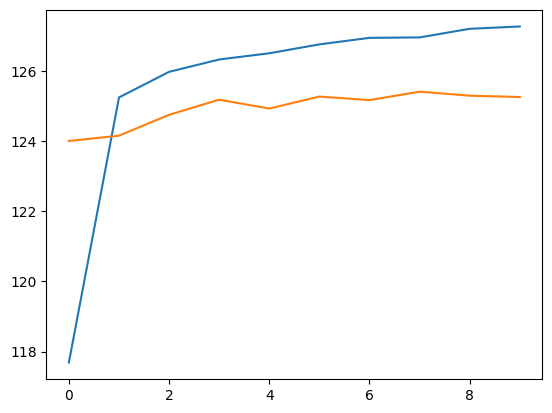

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_accuracy_train, label='Training accuracy')
plt.plot(list_accuracy_test, label='Test accuracy')
plt.xlabel("epoch")

    # Show the figure
plt.show()

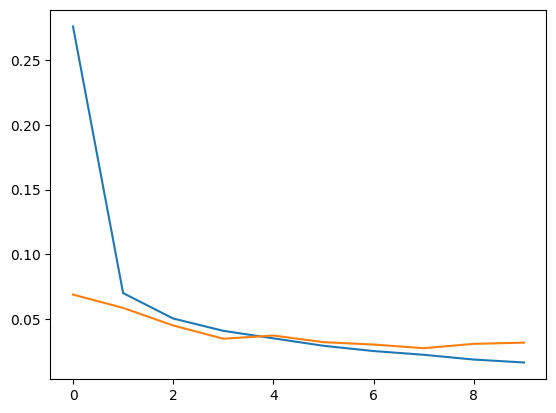

In [ ]:
plt.plot(list_loss_train, label='Training loss')
plt.plot(list_loss_test , label='Test accuracy')

    # Show the figure
plt.show()

In [ ]:
print(len(y_true))
print(len(y_pred))


100000
100000


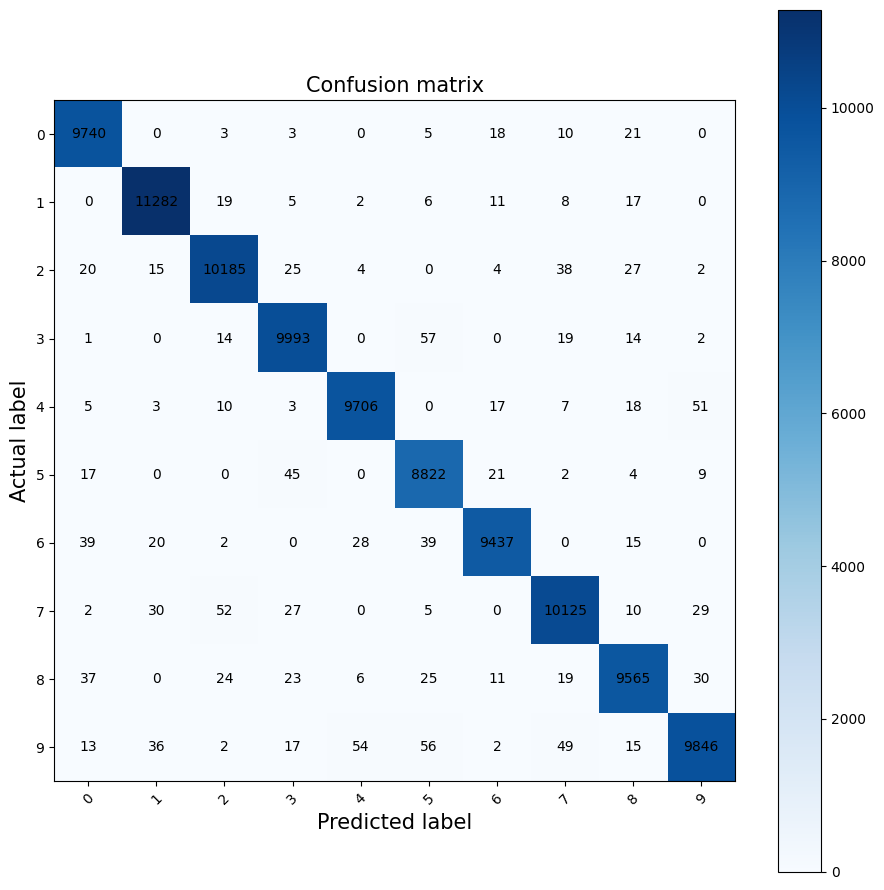

In [ ]:
import sklearn.metrics as metrics

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print with matplotlib
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0","1","2","3","4","5","6","7","8","9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0","1","2","3","4","5","6","7","8","9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x),
  horizontalalignment='center',
  verticalalignment='center')
plt.show()
